# Clasificación de Géneros Cinematográficos
## Curso: Aplicaciones de Aprendizaje de Máquina - MACC
**Autores:** Sergio Guarín, Oswald Morales, Jose Agudelo  
**Profesor:** Andres Nicolas Lopez Lopez  
**Periodo:** 2025-1

Este proyecto tiene como objetivo construir un modelo de clasificación que prediga el género de una película a partir de su sinopsis (`overview`). Para esto, se utilizan técnicas modernas de procesamiento de lenguaje natural, específicamente *embeddings* generados con `SentenceTransformers`, y algoritmos supervisados de clasificación.


In [51]:
#!pip freeze > requirements.txt

In [ ]:
#!pip install -r requirements.txt

In [7]:
import pandas as pd
import numpy as np
import ast
import os
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from utils import extract_genres, get_single_valid_genre
from collections import Counter
from pathlib import Path
from sentence_transformers import SentenceTransformer

from langchain.text_splitter import SentenceTransformersTokenTextSplitter
from sentence_transformers import SentenceTransformer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression


from langchain.text_splitter import SentenceTransformersTokenTextSplitter

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


En esta celda se utiliza la función `dataset_download` de `kagglehub` para descargar la versión más reciente del conjunto de datos **"The Movies Dataset"** desde Kaggle, un recurso ampliamente utilizado para análisis de datos relacionados con películas. Este dataset incluye información detallada como sinopsis, géneros, calificaciones y otros metadatos relevantes.

El resultado de la descarga se almacena en la variable `path`, que representa la ruta local donde se guardaron los archivos descargados. Esta ruta será utilizada en celdas posteriores para cargar los datos y comenzar el análisis.

In [8]:
path = kagglehub.dataset_download("rounakbanik/the-movies-dataset")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\Oswald\.cache\kagglehub\datasets\rounakbanik\the-movies-dataset\versions\7


### Carga y filtrado inicial de los datos

En esta celda se realiza la carga del archivo `movies_metadata.csv` que contiene información sobre las películas. Se extraen únicamente tres columnas relevantes para el análisis: `title` (título de la película), `overview` (sinopsis) y `genres` (géneros asociados).

Posteriormente, se elimina cualquier registro que no tenga sinopsis (`overview` nulo), ya que la descripción textual de la película es fundamental para los modelos de procesamiento de lenguaje natural (NLP) que se utilizarán más adelante.

Finalmente, se imprime el número de películas restantes y la forma del DataFrame, lo cual permite verificar cuántos datos quedaron disponibles después del filtrado inicial.
Cuando estés listo, compárteme el siguiente bloque.

In [9]:
file_name = Path(path, 'movies_metadata.csv')
df = pd.read_csv(file_name, low_memory=False)
df = df[['title', 'overview', 'genres']]
#  2. Eliminar películas sin sinopsis
df = df[df['overview'].notnull()]
print(f"Después de eliminar sinopsis vacías: {len(df)}")
print(f"Películas cargadas: {df.shape[0]}, columnas: {df.shape[1]}")

Después de eliminar sinopsis vacías: 44512
Películas cargadas: 44512, columnas: 3


Se muestra la informacion inicial del dataframe:

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44512 entries, 0 to 45465
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     44506 non-null  object
 1   overview  44512 non-null  object
 2   genres    44512 non-null  object
dtypes: object(3)
memory usage: 1.4+ MB


### Filtrado y codificación de géneros

En esta sección se realiza un filtrado adicional para asegurar que el análisis se centre únicamente en películas claramente clasificadas dentro de un solo género específico. Se sigue el siguiente procedimiento:

1. **Lista de géneros válidos**: Se define una lista de géneros aceptados (`valid_genres`) que serán considerados en el análisis. Esta selección permite enfocar el modelo en categorías comunes y bien representadas.

2. **Extracción de géneros**: A partir de la columna `genres`, se utiliza la función `extract_genres` para convertir cada entrada en una lista de géneros legibles (`genre_list`).

3. **Filtrado por un solo género**: Se conserva únicamente aquellas películas que pertenecen a **exactamente un género** y que además esté presente en la lista de géneros válidos. Esto permite simplificar el problema como una tarea de clasificación multiclase con una única etiqueta por película.

4. **Codificación del género**: Se crea un mapeo (`genre_to_code`) que asigna un número entero a cada género válido. Esta codificación numérica es necesaria para alimentar los algoritmos de clasificación.

5. **Eliminación de duplicados**: Finalmente, se eliminan registros duplicados basados en la combinación de título y sinopsis, lo que ayuda a evitar sesgos o redundancias durante el entrenamiento del modelo.

Este preprocesamiento es crucial para garantizar la calidad y consistencia de los datos antes de aplicar técnicas de procesamiento de texto y aprendizaje automático.

In [12]:
valid_genres = [
    "Drama", "Comedy", "Documentary", "Horror", "Thriller", "Western",
    "Action", "Animation", "Science Fiction", "Crime", "Music", "Adventure"
]


df['genre_list'] = df['genres'].apply(extract_genres)

#  5. Filtrar películas con exactamente un género válido
def get_single_valid_genre(g_list):
    return g_list[0] if len(g_list) == 1 and g_list[0] in valid_genres else None

df['genre'] = df['genre_list'].apply(get_single_valid_genre)
df = df[df['genre'].notnull()].copy()
print(f"Después de filtrar por género único válido: {len(df)}")

#  6. Codificar género
genre_to_code = {g: i for i, g in enumerate(sorted(valid_genres))}
df['genre_code'] = df['genre'].map(genre_to_code)

#  7. Eliminar duplicados exactos
df = df.drop_duplicates(subset=['title', 'overview']).reset_index(drop=True)
print(f"Después de eliminar duplicados exactos: {len(df)}")

Después de filtrar por género único válido: 13761
Después de eliminar duplicados exactos: 13754


### Asignación final de género y codificación categórica

En esta celda se realiza una asignación explícita del género principal de cada película, seleccionando el primer elemento de la lista `genre_list`. Dado que en el paso anterior ya se filtraron únicamente las películas con un solo género válido, esta operación garantiza que cada película tenga una única etiqueta de género.

Posteriormente, se convierte la columna `genre` a un tipo de dato categórico y se genera un código numérico (`genre_code`) asociado a cada categoría. Esta codificación es útil para representar los géneros como etiquetas numéricas que pueden ser procesadas por los modelos de aprendizaje automático en las etapas posteriores del análisis.


In [13]:
df['genre'] = df['genre_list'].apply(lambda x: x[0])
df['genre_code'] = df['genre'].astype('category').cat.codes

Se imprimen los datos finales, notese que concuerdan con los del modulo 1:

In [14]:
print("Películas tras limpieza:", df.shape[0])
print("Distribución por género:")
print(df['genre'].value_counts())

Películas tras limpieza: 13754
Distribución por género:
genre
Drama              4906
Comedy             3371
Documentary        2683
Horror              971
Thriller            455
Western             317
Action              276
Animation           237
Science Fiction     195
Crime               127
Music               109
Adventure           107
Name: count, dtype: int64


Se hace un grafico de barras para ver la distribucion de peliculas por genero, esto para vizualizar el posible desbalanceo de clases:

C:\Users\Oswald\AppData\Local\Temp\ipykernel_6120\2236700507.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')


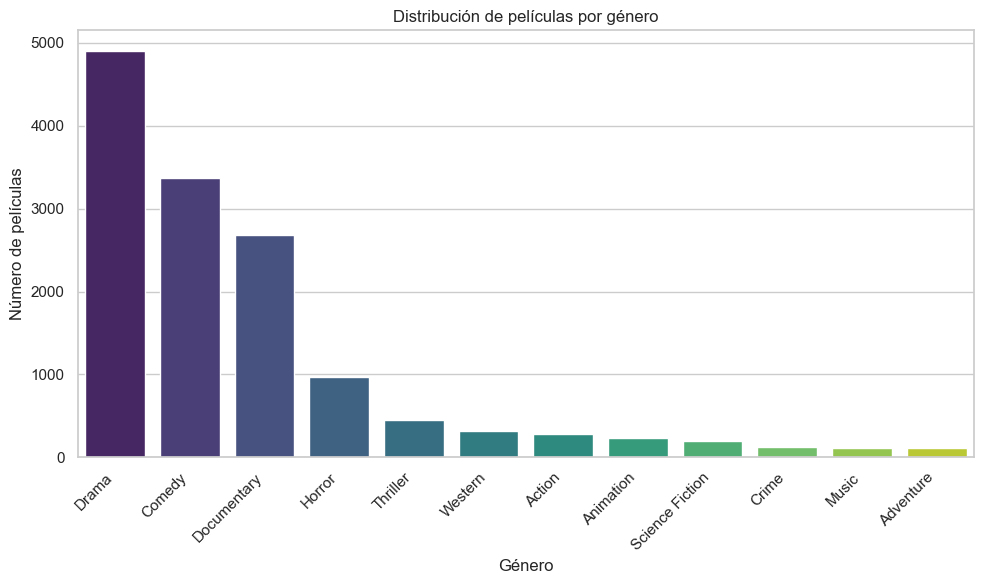

In [15]:
# Configuración de estilo
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Conteo de géneros
genre_counts = df['genre'].value_counts().sort_values(ascending=False)

# Gráfico de barras
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')

# Etiquetas y título
plt.xticks(rotation=45, ha='right')
plt.ylabel("Número de películas")
plt.xlabel("Género")
plt.title("Distribución de películas por género")
plt.tight_layout()
plt.show()

Se eliminan duplicados y se muestra informacion del dataset final:

In [16]:
# Eliminar duplicados por sinopsis
df_clean=df.copy()
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13754 entries, 0 to 13753
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       13754 non-null  object
 1   overview    13754 non-null  object
 2   genres      13754 non-null  object
 3   genre_list  13754 non-null  object
 4   genre       13754 non-null  object
 5   genre_code  13754 non-null  int8  
dtypes: int8(1), object(5)
memory usage: 550.8+ KB


### División de sinopsis por tokens y filtrado por longitud

En esta etapa se prepara el texto de las sinopsis para ser procesado por modelos de lenguaje basados en embeddings, utilizando un enfoque sensible al número de tokens. Se realiza lo siguiente:

1. **Inicialización del segmentador de texto**: Se crea un objeto `SentenceTransformersTokenTextSplitter`, el cual divide el texto en fragmentos basados en un máximo de 315 tokens por segmento, sin superposición (`chunk_overlap=0`). Esto es útil para modelos como MPNet que tienen un límite de tokens por entrada.

2. **Conteo de fragmentos por sinopsis**: Se define una función `count_chunks` que divide cada sinopsis y cuenta cuántos fragmentos resultan. Luego se aplica esta función a todas las sinopsis del DataFrame.

3. **Filtrado por longitud**: Se conservan únicamente aquellas sinopsis que pueden ser representadas en un solo bloque de tokens (≤ 315 tokens). Esto asegura que el texto pueda ser procesado de forma directa por el modelo sin necesidad de truncamiento o división adicional.

4. **Creación de variable objetivo binaria**: Se genera una nueva columna `target` que codifica el género como una variable binaria: `1` si la película es del género "Comedy" y `0` en caso contrario. Este paso convierte el problema en una tarea de clasificación binaria para los experimentos iniciales.

Este preprocesamiento garantiza que las entradas textuales cumplan con las restricciones de tamaño del modelo y permite establecer un conjunto de datos limpio y coherente para la clasificación binaria entre "Comedia" y "No Comedia".

In [17]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=315)

# Función para dividir y contar bloques por sinopsis
def count_chunks(text):
    chunks = token_splitter.split_text(text)
    return len(chunks)

# Aplicar a todas las sinopsis
df['num_chunks'] = df['overview'].apply(count_chunks)

# Filtrar para quedarnos solo con sinopsis que tienen 1 bloque
df_clean = df[df['num_chunks'] == 1].copy()
df_clean['target'] = df_clean['genre'].apply(lambda x: 1 if x == 'Comedy' else 0)
print(f"Películas con sinopsis de un solo bloque: {df_clean.shape[0]}")

Películas con sinopsis de un solo bloque: 13744


### Representación BoW (Bag of Words) y extracción de características

En esta celda se construye una representación numérica de las sinopsis utilizando el enfoque clásico de **Bolsa de Palabras (Bag of Words)**:

1. **Inicialización del vectorizador**: Se crea un objeto `CountVectorizer` de scikit-learn con eliminación de *stopwords* en inglés, es decir, palabras comunes que no aportan valor semántico significativo (como "the", "and", "is", etc.). Además, se limita el número de términos a los 5000 más frecuentes (`max_features=5000`) para controlar la dimensionalidad.

2. **Transformación de texto en vectores**: El vectorizador se ajusta a las sinopsis del conjunto `df_clean['overview']`, generando una matriz dispersa `X_bow` donde cada fila representa una película y cada columna representa un término del vocabulario, con el valor indicando la frecuencia de aparición del término en la sinopsis correspondiente.

3. **Extracción de etiquetas**: Se obtiene el vector de clases objetivo `y`, que contiene valores binarios (`1` para "Comedy", `0` para los demás géneros).

4. **Verificación de dimensiones**: Se imprimen las dimensiones de la matriz BoW para confirmar el número de películas procesadas y la cantidad de términos usados como características.

Esta representación será utilizada para entrenar modelos clásicos de clasificación textual, como la regresión logística o árboles de decisión.

In [18]:
vectorizer = CountVectorizer(stop_words='english', max_features=5000)  # puedes ajustar max_features si es necesario

# Aplicar a la columna overview
X_bow = vectorizer.fit_transform(df_clean['overview'])

# Etiquetas binarias
y = df_clean['target'].values

# Verificación de dimensiones
print(f"Matriz BoW: {X_bow.shape[0]} documentos, {X_bow.shape[1]} términos")

Matriz BoW: 13744 documentos, 5000 términos


### Evaluación de modelos LDA con distintas cantidades de tópicos

En esta sección se evalúa el desempeño de una arquitectura de clasificación basada en modelos temáticos (**Latent Dirichlet Allocation**, LDA) seguidos de un clasificador de regresión logística. El objetivo es determinar cuántos tópicos resultan más informativos para discriminar entre películas de comedia y no comedia.

1. **Definición de valores de tópicos**: Se prueba una lista de valores posibles para el número de tópicos (`n_topics_list`) que van desde 10 hasta 20, con incrementos de 2. Esto permite explorar cómo varía el desempeño del modelo al cambiar la granularidad temática.

2. **Validación cruzada estratificada**: Se utiliza validación cruzada estratificada de 10 particiones (`StratifiedKFold`) para asegurar que las proporciones entre clases se mantengan consistentes en cada fold. Esto es especialmente importante dado que se trata de un problema de clasificación binaria con posible desbalance.

3. **Pipeline temático + clasificador**:
   - Para cada valor de `n_topics`, se entrena un modelo LDA sobre la matriz BoW.
   - La salida del modelo LDA es una representación vectorial por documento basada en distribuciones de tópicos (`X_topics`).
   - Estas representaciones se usan como entrada para un modelo de regresión logística.

4. **Evaluación por ROC-AUC**:
   - Se entrena y evalúa el clasificador en cada partición de la validación cruzada.
   - Se calcula el **ROC-AUC**, una métrica robusta para problemas de clasificación binaria, que mide la capacidad del modelo para distinguir entre clases.

5. **Almacenamiento de resultados**: Se registra el valor promedio de ROC-AUC para cada número de tópicos, permitiendo posteriormente comparar y seleccionar el número óptimo.

Esta metodología permite cuantificar cómo el número de tópicos afecta la capacidad predictiva del modelo en una tarea de clasificación binaria.


In [19]:
# Valores de p a probar
n_topics_list = [10, 12, 14, 16, 18, 20]
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Guardar resultados
auc_results = {}

for n_topics in n_topics_list:
    print(f"\nEvaluando modelo con {n_topics} tópicos...")
    
    # Modelo LDA
    lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42, learning_method='batch')
    
    # Pipeline: LDA → Regresión logística
    def get_topic_features(X):
        return lda_model.fit_transform(X)

    # Generar representación temática para todo el corpus (X_bow)
    X_topics = get_topic_features(X_bow)
    
    # Clasificador
    clf = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
    
    # Validación cruzada manual (con ROC-AUC)
    scores = []
    for train_idx, test_idx in kfold.split(X_topics, y):
        X_train, X_test = X_topics[train_idx], X_topics[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, y_prob)
        scores.append(score)
    
    mean_auc = np.mean(scores)
    auc_results[n_topics] = mean_auc
    print(f"ROC-AUC promedio para {n_topics} tópicos: {mean_auc:.4f}")


Evaluando modelo con 10 tópicos...
ROC-AUC promedio para 10 tópicos: 0.6869

Evaluando modelo con 12 tópicos...
ROC-AUC promedio para 12 tópicos: 0.7337

Evaluando modelo con 14 tópicos...
ROC-AUC promedio para 14 tópicos: 0.7239

Evaluando modelo con 16 tópicos...
ROC-AUC promedio para 16 tópicos: 0.7425

Evaluando modelo con 18 tópicos...
ROC-AUC promedio para 18 tópicos: 0.7413

Evaluando modelo con 20 tópicos...
ROC-AUC promedio para 20 tópicos: 0.7114


### Entrenamiento final del modelo LDA con 16 tópicos

Luego de evaluar múltiples configuraciones, se selecciona el modelo LDA con **16 tópicos**, ya que este número proporcionó un buen equilibrio entre capacidad de representación y desempeño predictivo en la validación cruzada anterior.

- Se entrena un modelo final `lda_final` usando `LatentDirichletAllocation` con `n_components=16`, lo que indica que se extraerán 16 temas latentes a partir del corpus representado por la matriz BoW.
- El resultado (`X_topics_final`) es una matriz donde cada fila representa una película y cada columna representa la proporción de asociación de esa película a uno de los 16 tópicos.

Esta representación temática comprimida puede ser utilizada para tareas de visualización, análisis interpretativo o como entrada para modelos de clasificación más avanzados.


In [20]:
lda_final = LatentDirichletAllocation(n_components=16, random_state=42, learning_method='batch')
X_topics_final = lda_final.fit_transform(X_bow)

### Exploración de palabras clave por tema (LDA)

Esta celda permite interpretar los **temas aprendidos por el modelo LDA** examinando las palabras más representativas de cada uno:

1. **Extracción del vocabulario**: Se recuperan los términos del modelo `CountVectorizer` utilizado previamente para construir la matriz BoW. Este vocabulario (`vocab`) permite mapear los índices de los tópicos a palabras reales.

2. **Selección de palabras clave**: Para cada uno de los 16 temas descubiertos por el modelo `lda_final`, se seleccionan las 5 palabras con mayor peso (es decir, las que más contribuyen a ese tópico).

3. **Visualización**: Se imprime una lista de palabras clave para cada tema. Esto permite al usuario obtener una **visión cualitativa** del contenido semántico de los tópicos y comprobar si tienen coherencia interpretativa (por ejemplo, si agrupan palabras relacionadas con géneros, emociones, escenarios o personajes).

Esta interpretación temática es una de las fortalezas del LDA, ya que permite extraer conocimiento útil incluso en ausencia de etiquetas.


In [21]:
vocab = vectorizer.get_feature_names_out()
n_top_words = 5

print("🔍 Palabras clave por tema:\n")
for topic_idx, topic in enumerate(lda_final.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_words = [vocab[i] for i in top_features_ind]
    print(f"Tema {topic_idx + 1}: {', '.join(top_words)}")

🔍 Palabras clave por tema:

Tema 1: new, man, young, story, film
Tema 2: man, world, years, young, death
Tema 3: woman, young, wife, husband, man
Tema 4: life, love, town, daughter, girl
Tema 5: family, father, life, mother, old
Tema 6: comedy, special, new, stand, life
Tema 7: young, friends, job, new, time
Tema 8: war, world, story, south, people
Tema 9: film, films, movie, la, james
Tema 10: life, man, prison, friend, space
Tema 11: friends, world, life, year, lives
Tema 12: team, story, football, town, time
Tema 13: school, high, students, teacher, girl
Tema 14: film, documentary, world, life, story
Tema 15: men, life, lives, women, new
Tema 16: group, money, local, people, police


### Entrenamiento del clasificador final con representaciones LDA

En esta etapa se entrena el **modelo de clasificación final**, utilizando como entrada la representación temática generada por el modelo LDA:

- Se utiliza un clasificador de **Regresión Logística** (`LogisticRegression`) con un máximo de 1000 iteraciones para asegurar la convergencia y el solver `'liblinear'`, que es adecuado para conjuntos de datos pequeños o medianos y problemas de clasificación binaria.

- El modelo se entrena sobre `X_topics_final`, que contiene las proporciones de asociación de cada película a los 16 temas descubiertos por LDA, y `y`, que representa la etiqueta binaria (`1` si es comedia, `0` si no lo es).

Este clasificador aprovecha las características temáticas para predecir si una película pertenece o no al género "Comedy", basándose en los patrones latentes aprendidos por el modelo LDA.


In [22]:
clf_final = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
clf_final.fit(X_topics_final, y)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

### Interpretación de los coeficientes del modelo de regresión

Esta celda muestra cómo cada uno de los 16 tópicos extraídos por el modelo LDA contribuye a la predicción del género **"Comedy"** en la regresión logística:

- Se extraen los **coeficientes** del modelo (`clf_final.coef_`), que indican la relación entre la presencia de un tópico en una película y la probabilidad de que esta sea clasificada como comedia.

- Cada coeficiente se imprime junto con una flecha que indica la **dirección del efecto**:
  - **↗️ (positivo)**: El tópico está asociado positivamente con el género "Comedy", es decir, su presencia incrementa la probabilidad de que la película sea una comedia.
  - **↘️ (negativo)**: El tópico está asociado negativamente con "Comedy", lo que sugiere que es más frecuente en películas de otros géneros.

Este análisis ayuda a identificar qué temas son característicos de las comedias y cuáles no, proporcionando una interpretación más profunda del modelo.


In [48]:
# Coeficientes de la regresión
coefficients = clf_final.coef_[0]

print("\n📈 Coeficientes del modelo de regresión (relación con 'Comedy'):")
for i, coef in enumerate(coefficients):
    direction = "↗️" if coef > 0 else "↘️"
    print(f"Tema {i+1}: coef = {coef:.4f} {direction}")


📈 Coeficientes del modelo de regresión (relación con 'Comedy'):
Tema 1: coef = 0.3121 ↗️
Tema 2: coef = -1.2609 ↘️
Tema 3: coef = -0.0042 ↘️
Tema 4: coef = 0.8670 ↗️
Tema 5: coef = -0.6015 ↘️
Tema 6: coef = 3.5170 ↗️
Tema 7: coef = 1.0881 ↗️
Tema 8: coef = -1.9289 ↘️
Tema 9: coef = 0.4362 ↗️
Tema 10: coef = -1.2946 ↘️
Tema 11: coef = 0.7141 ↗️
Tema 12: coef = 0.2547 ↗️
Tema 13: coef = 0.8596 ↗️
Tema 14: coef = -3.4963 ↘️
Tema 15: coef = -0.5377 ↘️
Tema 16: coef = 0.0547 ↗️


### Visualización: Mapa de calor de palabras clave por tema (LDA)

Esta celda genera un **heatmap (mapa de calor)** que muestra la relación entre las palabras más importantes del vocabulario y los temas identificados por el modelo LDA. El objetivo es facilitar la interpretación de los tópicos de forma visual.

#### Pasos realizados:

1. **Selección de palabras clave**:
   - Se identifican las `n_top_words` (5 por tema) con mayor peso dentro de cada uno de los tópicos generados por LDA.
   - Estas palabras representan el núcleo semántico de cada tema.

2. **Construcción de la matriz de pesos**:
   - Se crea una tabla (`df_heatmap`) donde cada fila corresponde a un tema y cada columna a una palabra clave. El valor en cada celda indica el **peso** (importancia) de esa palabra en ese tema, según el modelo LDA.

3. **Normalización**:
   - Se normaliza cada fila para que los pesos de las palabras sean relativos al total del tema, facilitando la comparación entre palabras dentro del mismo tópico.

4. **Visualización con seaborn**:
   - Se genera un heatmap con `seaborn`, donde las celdas más oscuras indican mayor relevancia de una palabra dentro de un tema.
   - El eje X representa los temas y el eje Y las palabras clave utilizadas.

Esta visualización complementa el análisis anterior de coeficientes, permitiendo ver **qué palabras caracterizan a los temas más relacionados (positiva o negativamente) con el género "Comedy"**.


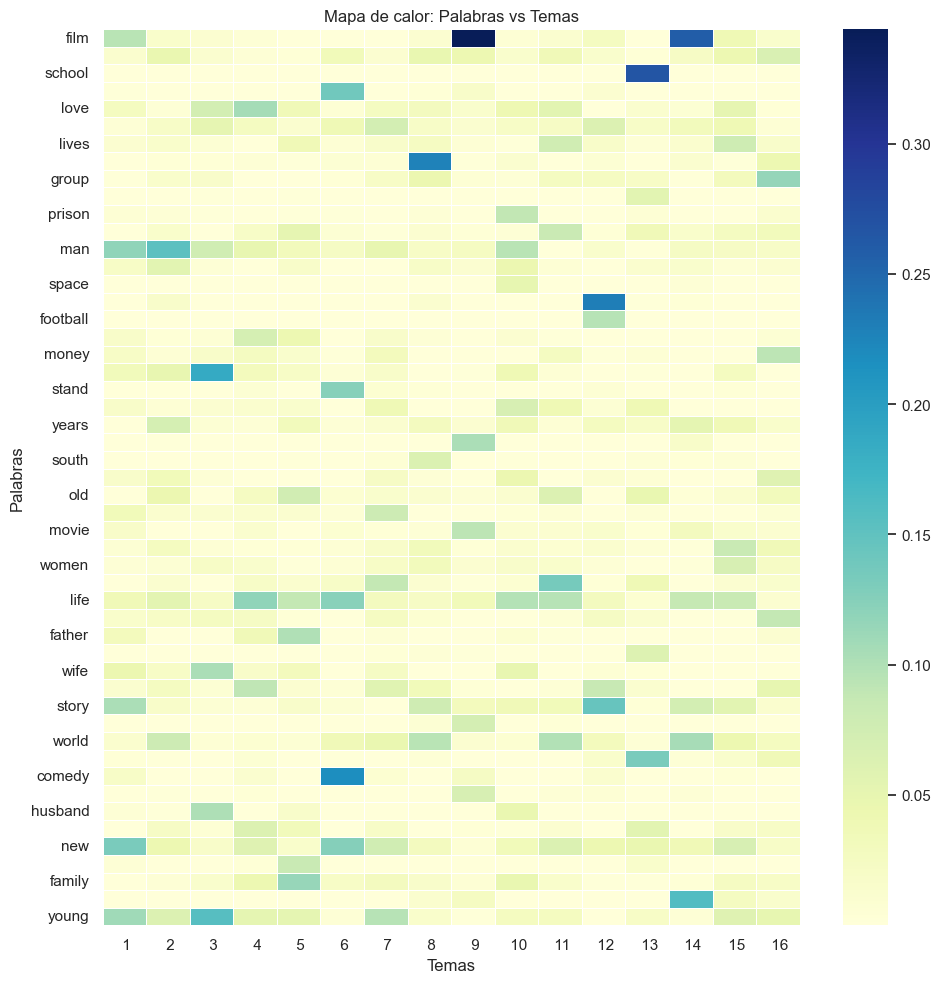

In [24]:
# Número de palabras principales por tema
n_top_words = 5
n_topics = lda_final.n_components
vocab = vectorizer.get_feature_names_out()

# Obtener las n_top_words más importantes por tema
top_words_per_topic = []
for topic in lda_final.components_:
    top_indices = topic.argsort()[-n_top_words:][::-1]
    top_words_per_topic.append([vocab[i] for i in top_indices])

# Crear una tabla de pesos para esas palabras
data = []
words = list(set(word for topic in top_words_per_topic for word in topic))
for i, topic in enumerate(lda_final.components_):
    row = []
    for word in words:
        idx = np.where(vocab == word)[0]
        weight = topic[idx[0]] if len(idx) > 0 else 0
        row.append(weight)
    data.append(row)

# Convertir a DataFrame
df_heatmap = pd.DataFrame(data, columns=words, index=[f" {i+1}" for i in range(n_topics)])

# Normalizar por fila para mejorar la visualización
df_heatmap_norm = df_heatmap.div(df_heatmap.sum(axis=1), axis=0)

# Crear heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(df_heatmap_norm.T, cmap="YlGnBu", annot=False, linewidths=0.5)
plt.title("Mapa de calor: Palabras vs Temas")
plt.ylabel("Palabras")
plt.xlabel("Temas")
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Predicción de género en nuevas sinopsis

Esta celda pone en práctica el modelo entrenado para predecir la probabilidad de que nuevas películas pertenezcan al género **"Comedy"**, utilizando sinopsis inéditas (ficticias o reales).

#### Flujo de procesamiento:

1. **Nuevas sinopsis**: Se definen tres descripciones de películas que no están en el conjunto original, lo que permite probar la capacidad generalizadora del modelo.

2. **Vectorización**: Las nuevas sinopsis se transforman en representaciones BoW utilizando el mismo `vectorizer` previamente ajustado al corpus original. Esto garantiza que las nuevas entradas estén alineadas con el vocabulario del modelo.

3. **Distribución de temas (LDA)**: Las sinopsis vectorizadas se transforman con el modelo LDA (`lda_final`) para obtener sus representaciones temáticas, en la misma forma que las películas del conjunto de entrenamiento.

4. **Predicción**: El clasificador final (`clf_final`) utiliza estas representaciones temáticas para predecir la **probabilidad de que cada sinopsis sea una comedia**.

5. **Visualización de resultados**: Se imprime cada sinopsis junto con su probabilidad de pertenecer al género "Comedy", permitiendo evaluar la intuición del modelo ante ejemplos nuevos.

Esta etapa demuestra la **aplicabilidad real del pipeline**, donde el texto pasa por todos los pasos del preprocesamiento, modelado temático y clasificación binaria, para llegar a una predicción final.


In [25]:

nuevas_sinopsis = [
    "A detective accidentally joins a clown school and must juggle his double life to solve a circus crime.",
    "After a tragic loss, a man moves to the Arctic and trains wolves to hunt ghosts.",
    "A group of teens build a time machine and travel back to warn Shakespeare about memes."
]

# Vectorizar las nuevas sinopsis usando el mismo vectorizer
X_nuevo_bow = vectorizer.transform(nuevas_sinopsis)

# Obtener distribución de temas
X_nuevo_topics = lda_final.transform(X_nuevo_bow)

# Predecir probabilidades con el modelo final
probs = clf_final.predict_proba(X_nuevo_topics)[:, 1]

# Mostrar resultados
for i, (sinopsis, prob) in enumerate(zip(nuevas_sinopsis, probs), 1):
    print(f"\n🎬 Sinopsis {i}:\n{sinopsis}")
    print(f"Probabilidad de que sea 'Comedy': {prob:.4f}")


🎬 Sinopsis 1:
A detective accidentally joins a clown school and must juggle his double life to solve a circus crime.
Probabilidad de que sea 'Comedy': 0.3520

🎬 Sinopsis 2:
After a tragic loss, a man moves to the Arctic and trains wolves to hunt ghosts.
Probabilidad de que sea 'Comedy': 0.1620

🎬 Sinopsis 3:
A group of teens build a time machine and travel back to warn Shakespeare about memes.
Probabilidad de que sea 'Comedy': 0.2694


In [26]:
nuevas_sinopsis = [
    # Comedia clásica
    "Two roommates accidentally adopt a raccoon, mistaking it for a cat. Chaos and laughter ensue as it destroys their apartment.",
    
    # Sátira política
    "In a nation where voting is determined by dance-offs, a retired ballet dancer stages a comeback to restore democracy.",
    
    # Romance dramático
    "A young woman falls in love with a man who believes he's from another century. As love blooms, reality begins to fade.",
    
    # Comedia absurda
    "An unemployed magician opens a bakery that only sells invisible bread and becomes a global sensation.",
    
    # Acción seria
    "An elite soldier must infiltrate a high-security prison to retrieve stolen launch codes before time runs out.",
    
    # Thriller psicológico
    "A blind sculptor starts to see through his hands and discovers terrifying secrets buried in his latest work."
]
# Vectorizar
X_nuevo_bow = vectorizer.transform(nuevas_sinopsis)

# Obtener temas
X_nuevo_topics = lda_final.transform(X_nuevo_bow)

# Predecir probabilidades
probs = clf_final.predict_proba(X_nuevo_topics)[:, 1]

# Mostrar resultados
for i, (sinopsis, prob) in enumerate(zip(nuevas_sinopsis, probs), 1):
    print(f"\n🎬 Sinopsis {i}:\n{sinopsis}")
    print(f"Probabilidad de que sea 'Comedy': {prob:.4f}")


🎬 Sinopsis 1:
Two roommates accidentally adopt a raccoon, mistaking it for a cat. Chaos and laughter ensue as it destroys their apartment.
Probabilidad de que sea 'Comedy': 0.4805

🎬 Sinopsis 2:
In a nation where voting is determined by dance-offs, a retired ballet dancer stages a comeback to restore democracy.
Probabilidad de que sea 'Comedy': 0.2087

🎬 Sinopsis 3:
A young woman falls in love with a man who believes he's from another century. As love blooms, reality begins to fade.
Probabilidad de que sea 'Comedy': 0.1981

🎬 Sinopsis 4:
An unemployed magician opens a bakery that only sells invisible bread and becomes a global sensation.
Probabilidad de que sea 'Comedy': 0.1666

🎬 Sinopsis 5:
An elite soldier must infiltrate a high-security prison to retrieve stolen launch codes before time runs out.
Probabilidad de que sea 'Comedy': 0.2941

🎬 Sinopsis 6:
A blind sculptor starts to see through his hands and discovers terrifying secrets buried in his latest work.
Probabilidad de que se

### Entrenamiento de modelos sLDA por género (clasificación binaria uno-vs-rest)

Esta función permite entrenar un conjunto de modelos temáticos supervisados para clasificación binaria, donde **cada género válido se trata como una clase positiva frente a todas las demás**. Esta estrategia sigue un enfoque **one-vs-rest** y utiliza una combinación de LDA y regresión logística.

#### Detalles del proceso:

- **Entradas**:
  - `df_texts`: DataFrame con los textos y etiquetas (`genre`).
  - `X_bow`: Matriz de representación BoW del corpus completo.
  - `genres`: Lista de géneros válidos que se desea modelar.
  - `n_topics`: Número de tópicos a extraer en el modelo LDA.

- **Lógica del entrenamiento**:
  - Para cada género, se crea una variable binaria: `1` si la película pertenece a ese género, `0` si no.
  - Se entrena un modelo LDA con `n_topics` tópicos sobre la matriz BoW. Aunque todos los géneros comparten la misma matriz de entrada, cada LDA es entrenado individualmente, lo que permite capturar patrones específicos para cada género.
  - La salida de LDA (distribuciones temáticas) se utiliza como entrada para un clasificador de regresión logística.
  - Cada modelo (LDA + clasificador) se almacena en un diccionario bajo la clave del género correspondiente.

- **Salida**:
  - Un diccionario `models` que contiene, para cada género, el modelo LDA entrenado y su clasificador asociado.

Esta estructura modular permite realizar predicciones independientes por género y facilita la comparación del comportamiento del modelo en tareas de clasificación binaria por separado.

In [27]:
def train_slda_models(df_texts, X_bow, genres, n_topics):

    models = {}

    for genre in genres:
        print(f"Entrenando modelo para género: {genre}")

        # Codificar target binaria para ese género
        y = df_texts['genre'].apply(lambda g: 1 if g == genre else 0).values

        # LDA
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, learning_method='batch')
        X_topics = lda.fit_transform(X_bow)

        # Clasificador
        clf = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
        clf.fit(X_topics, y)

        # Guardar modelo
        models[genre] = {'lda': lda, 'clf': clf}

    return models

Se utilizan 16 topicos para todos los generos, notese que esto solo fue validado para el genero de comedia y quiza un numero diferente de topicos pueda ser mejor para los otros generos, sin embargo, para mantener la estructura, se decide utilizar un numero de topicos constante.

In [28]:
slda_models = train_slda_models(df_clean, X_bow, valid_genres, n_topics=16)

Entrenando modelo para género: Drama
Entrenando modelo para género: Comedy
Entrenando modelo para género: Documentary
Entrenando modelo para género: Horror
Entrenando modelo para género: Thriller
Entrenando modelo para género: Western
Entrenando modelo para género: Action
Entrenando modelo para género: Animation
Entrenando modelo para género: Science Fiction
Entrenando modelo para género: Crime
Entrenando modelo para género: Music
Entrenando modelo para género: Adventure


### Función de predicción con modelos sLDA para múltiples géneros

Esta función permite predecir la probabilidad de que una o más sinopsis pertenezcan a distintos géneros cinematográficos, utilizando los modelos **sLDA entrenados previamente** (uno por género).

#### Descripción del flujo:

1. **Vectorización del texto**:
   - Se transforma la lista de nuevas sinopsis (`sinopsis_list`) en su representación de **Bolsa de Palabras (BoW)** utilizando el mismo `vectorizer` usado en el entrenamiento. Esto garantiza compatibilidad con los modelos.

2. **Predicción por género**:
   - Para cada género presente en el diccionario `slda_models`, se obtiene:
     - El modelo LDA entrenado para ese género.
     - El clasificador binario correspondiente.
   - Cada sinopsis se transforma mediante el LDA específico del género, generando su distribución de tópicos.
   - El clasificador predice la **probabilidad de que la sinopsis pertenezca a ese género** usando la distribución temática como entrada.

3. **Construcción de resultados**:
   - Se arma un `DataFrame` donde:
     - Cada **fila** representa una sinopsis.
     - Cada **columna** representa un género.
     - Cada **celda** contiene la probabilidad asignada por el modelo sLDA correspondiente a ese género.

Este esquema permite realizar **predicciones multiclase no excluyentes**, ya que cada modelo se entrenó de forma binaria e independiente. Así, una misma sinopsis puede recibir altas probabilidades en varios géneros si su contenido lo justifica.


In [29]:
def predict_with_slda_models(sinopsis_list, vectorizer, slda_models):

    bow = vectorizer.transform(sinopsis_list)
    pred_dict = {}

    for genre, model in slda_models.items():
        lda = model['lda']
        clf = model['clf']

        topic_dist = lda.transform(bow)
        probas = clf.predict_proba(topic_dist)[:, 1]
        pred_dict[genre] = probas

    return pd.DataFrame(pred_dict, index=[f"Sinopsis {i+1}" for i in range(len(sinopsis_list))])

### Predicción multigénero para nuevas sinopsis usando modelos sLDA

En esta celda se aplican los modelos sLDA entrenados previamente para estimar las **probabilidades de pertenencia a cada género** en un conjunto de nuevas sinopsis:

1. **Nuevas sinopsis**:
   - Se definen cuatro descripciones de películas (ficticias), cada una con un tono distinto: comedia absurda, ciencia ficción distópica, western sobrenatural, entre otros.

2. **Predicción con modelos sLDA**:
   - Se utiliza la función `predict_with_slda_models` para obtener una predicción por cada género. Esta función transforma las sinopsis al espacio de tópicos específico de cada modelo y aplica su clasificador binario respectivo.

3. **Visualización de resultados**:
   - El resultado es un `DataFrame` (`pred_df`) donde:
     - Cada fila representa una sinopsis.
     - Cada columna muestra la **probabilidad de pertenecer a uno de los géneros válidos**.
   - Se aplica redondeo a 3 decimales para facilitar la interpretación visual.

Este análisis permite observar **la distribución probabilística de géneros** para cada texto, ofreciendo una forma más rica y flexible de clasificación que los enfoques multiclase excluyentes. Además, muestra la capacidad del sistema para capturar matices temáticos en sinopsis no vistas durante el entrenamiento.



In [30]:
nuevas_sinopsis = [
    "A clown detective solves mysteries using rubber chickens and laughter.",
    "A war hero returns home to discover his town has been taken over by sentient vending machines.",
    "In the distant future, music is illegal and a rebel violinist fights to bring it back.",
    "A haunted western saloon keeps reliving the same poker game for eternity."
]

pred_df = predict_with_slda_models(nuevas_sinopsis, vectorizer, slda_models)
pred_df.round(3)

,Drama,Comedy,Documentary,Horror,Thriller,Western,Action,Animation,Science Fiction,Crime,Music,Adventure
Sinopsis 1,0.154,0.266,0.225,0.024,0.015,0.006,0.009,0.010,0.006,0.005,0.014,0.003
Sinopsis 2,0.307,0.086,0.296,0.132,0.027,0.048,0.031,0.021,0.071,0.004,0.002,0.025
Sinopsis 3,0.285,0.056,0.357,0.091,0.023,0.026,0.020,0.015,0.066,0.005,0.004,0.013
Sinopsis 4,0.233,0.192,0.116,0.145,0.047,0.052,0.042,0.043,0.022,0.011,0.005,0.015


### Generación de embeddings densos con MPNet para clasificación multiclase

En esta celda se transforma el texto de las sinopsis en **representaciones numéricas densas** utilizando el modelo preentrenado **MPNet** (`all-mpnet-base-v2`), una arquitectura de *transformers* optimizada para tareas de similitud semántica y clasificación.

#### Proceso paso a paso:

1. **Carga del modelo MPNet**:
   - Se utiliza la versión `all-mpnet-base-v2` del repositorio `sentence-transformers`, que permite obtener vectores de alta calidad semántica para textos completos.

2. **Cálculo de embeddings**:
   - Se aplica el método `.encode()` sobre la lista de sinopsis (`overview`), generando un **embedding vectorial** por sinopsis. Estos vectores capturan el contenido semántico de cada película de forma densa y continua.

3. **Conversión a NumPy**:
   - Los embeddings resultantes se almacenan como un arreglo `NumPy` (`X_mpnet`) para facilitar su uso en modelos de clasificación posteriores.

4. **Preparación de etiquetas multiclase**:
   - Se codifica la variable `genre` como una **etiqueta categórica** con valores numéricos (0, 1, 2, ..., N), donde cada valor representa un género diferente.
   - También se almacena la lista de nombres de los géneros (`genre_names`) para facilitar la interpretación posterior de resultados.

Este conjunto de embeddings servirá como entrada para entrenar clasificadores multiclase más potentes, que pueden aprovechar la riqueza semántica del modelo MPNet.


In [31]:
model_mpnet = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embeddings = model_mpnet.encode(df_clean['overview'].tolist(), show_progress_bar=True)
X_mpnet = np.array(embeddings)

y_genre = df_clean['genre'].astype('category')
y_labels = y_genre.cat.codes  # valores enteros 0 a 11 o 12
genre_names = y_genre.cat.categories.tolist()

Batches:   0%|          | 0/430 [00:00<?, ?it/s]

### Entrenamiento del clasificador multiclase usando embeddings MPNet

En esta celda se entrena un modelo de clasificación multiclase utilizando como entrada los embeddings generados previamente con MPNet. A diferencia del enfoque basado en sLDA (uno-vs-rest por género con tópicos), este modelo aprovecha directamente los vectores densos semánticos.

#### Pasos realizados:

1. **División del conjunto de datos**:
   - Se divide el conjunto en entrenamiento y prueba mediante `train_test_split`, utilizando un 80% de los datos para entrenamiento y 20% para validación.
   - Se mantiene la proporción de clases usando `stratify=y_labels` para evitar sesgos por desbalanceo.

2. **Configuración del clasificador**:
   - Se utiliza `OneVsRestClassifier` junto con **regresión logística** para abordar el problema multiclase como una serie de problemas binarios independientes, uno por clase.
   - Se ajusta un modelo por género usando los embeddings densos (`X_train`) como entrada.

3. **Entrenamiento**:
   - El clasificador se entrena con un máximo de 1000 iteraciones por clase para asegurar convergencia, utilizando el solver `'liblinear'`, eficiente para conjuntos de datos moderados.

Este enfoque ofrece un contraste con el pipeline basado en tópicos, permitiendo comparar si los embeddings preentrenados mejoran la capacidad de predicción sobre los géneros cinematográficos.


In [32]:
# Separar conjunto de entrenamiento (opcional, o usar todo el dataset)
X_train, X_test, y_train, y_test = train_test_split(X_mpnet, y_labels, stratify=y_labels, test_size=0.2, random_state=42)

# Clasificador multiclase
clf_mpnet = OneVsRestClassifier(LogisticRegression(max_iter=1000, solver='liblinear'))
clf_mpnet.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000,
                                                 solver='liblinear'))

### Predicción de género multiclase con embeddings MPNet

En esta celda se utiliza el clasificador multiclase entrenado previamente para predecir el **género más probable** de un conjunto de nuevas sinopsis, esta vez usando representaciones densas generadas por MPNet.

#### Flujo del proceso:

1. **Nuevas sinopsis**:
   - Se definen cuatro sinopsis inéditas que abarcan distintos contextos narrativos (humor, ciencia ficción, western, distopía musical), pensadas para evaluar la capacidad del modelo de generalizar sobre textos no vistos.

2. **Generación de embeddings**:
   - Las sinopsis se codifican usando el modelo `model_mpnet`, produciendo vectores densos que representan el contenido semántico de cada texto.

3. **Predicción con el clasificador multiclase**:
   - Se aplica el modelo `clf_mpnet` para obtener las **probabilidades de pertenencia a cada uno de los géneros** previamente definidos.

4. **Selección del género más probable**:
   - Para cada sinopsis, se identifica el género con la probabilidad más alta (`np.argmax(row)`), lo que equivale a la predicción final del modelo.

Este paso permite comparar directamente el enfoque basado en embeddings densos con el método anterior basado en sLDA + tópicos, evaluando cuál ofrece predicciones más intuitivas y precisas en el contexto del problema.


In [33]:
nuevas_sinopsis = [
    "A clown detective solves mysteries using rubber chickens and laughter.",
    "A war hero returns home to discover his town has been taken over by sentient vending machines.",
    "In the distant future, music is illegal and a rebel violinist fights to bring it back.",
    "A haunted western saloon keeps reliving the same poker game for eternity."
]

# Embeddings con MPNet
X_nuevas_embed = model_mpnet.encode(nuevas_sinopsis)

# Predicción de probabilidades por clase
probs_mpnet = clf_mpnet.predict_proba(X_nuevas_embed)

# Género más probable
predicted_genres = [genre_names[np.argmax(row)] for row in probs_mpnet]

### Comparación de predicciones: sLDA vs MPNet

Esta celda crea un **resumen comparativo** entre los dos enfoques de clasificación de género utilizados en el proyecto:

- **sLDA (LDA + Regresión Logística por género)**: basado en tópicos extraídos de la matriz BoW.
- **MPNet (embeddings densos + Regresión Logística multiclase)**: basado en representaciones semánticas obtenidas con un modelo preentrenado.

#### Componentes del análisis:

1. **Predicción sLDA**:
   - Para cada sinopsis, se selecciona el género con mayor probabilidad asignada por el sistema sLDA (`idxmax`) y se almacena junto con su nivel de confianza (`max`).

2. **Predicción MPNet**:
   - Se recupera el género con mayor probabilidad según el clasificador multiclase basado en embeddings densos (`predicted_genres`) y su correspondiente valor de confianza.

3. **Construcción del DataFrame comparativo**:
   - Se crea `df_comparacion`, un resumen claro que permite revisar, para cada sinopsis:
     - El texto original.
     - Las predicciones de género realizadas por ambos modelos.
     - Los niveles de confianza de cada predicción.

Esta tabla final permite evaluar **diferencias en las predicciones** entre ambos enfoques, identificar coincidencias y explorar en qué casos uno u otro sistema parece captar mejor el contenido temático de la sinopsis.


In [49]:
# Recoger la predicción más probable del sistema sLDA
predicted_slda_genres = pred_df.idxmax(axis=1)
slda_confidences = pred_df.max(axis=1)

# Crear DataFrame comparativo
df_comparacion = pd.DataFrame({
    'Sinopsis': nuevas_sinopsis,
    'Predicción sLDA': predicted_slda_genres.values,
    'Confianza sLDA': slda_confidences.round(3).values,
    'Predicción MPNet': predicted_genres,
    'Confianza MPNet': probs_mpnet.max(axis=1).round(3)
})
df_comparacion

,Sinopsis,Predicción sLDA,Confianza sLDA,Predicción MPNet,Confianza MPNet
0,A clown detective solves mysteries using rubbe...,Comedy,0.266,Comedy,0.699
1,A war hero returns home to discover his town h...,Drama,0.307,Comedy,0.243
2,"In the distant future, music is illegal and a ...",Documentary,0.357,Drama,0.576
3,A haunted western saloon keeps reliving the sa...,Drama,0.233,Horror,0.491


### Predicción de género en todo el conjunto con MPNet

En esta celda se utiliza el clasificador multiclase basado en **embeddings MPNet** para predecir el género más probable de todas las sinopsis del conjunto de datos original (`df_clean`).

#### Detalles del procedimiento:

1. **Predicción de probabilidades**:
   - Se calcula la **distribución completa de probabilidades** por género para cada sinopsis del conjunto, aplicando `predict_proba()` sobre los embeddings `X_mpnet`.

2. **Categorización final por sinopsis**:
   - Para cada sinopsis, se selecciona el género con mayor probabilidad (`np.argmax(p)`), lo que representa la predicción final del modelo (`y_pred_mpnet`).

3. **Nivel de confianza**:
   - Se extrae el valor máximo de probabilidad en cada caso (`proba_pred_mpnet`), el cual representa el **nivel de confianza** con el que el modelo asocia la sinopsis al género predicho.

Este paso permite realizar análisis adicionales como la evaluación de métricas (precisión, recall, F1), detección de errores de clasificación o la visualización de predicciones con distintos umbrales de confianza.


In [35]:
probs_mpnet_all = clf_mpnet.predict_proba(X_mpnet)
y_pred_mpnet = [genre_names[np.argmax(p)] for p in probs_mpnet_all]
proba_pred_mpnet = probs_mpnet_all.max(axis=1)

### Predicción de género en todo el conjunto usando modelos sLDA

Esta celda aplica los **modelos binarios sLDA entrenados por género** para predecir el género más probable de cada película en el conjunto completo (`df_clean`).

#### Detalles del procedimiento:

1. **Predicción individual por género**:
   - Para cada género, se utiliza su modelo `sLDA` (LDA + regresión logística) para transformar la matriz `X_bow` en distribuciones temáticas y predecir la **probabilidad de pertenecer a ese género**.

2. **Construcción de matriz de predicciones**:
   - Se compila un `DataFrame` (`df_slda_pred`) donde:
     - Cada **fila** representa una película.
     - Cada **columna** representa un género.
     - Cada **celda** contiene la probabilidad predicha por el modelo binario correspondiente.

3. **Determinación del género más probable por película**:
   - Para cada fila, se selecciona el género con **mayor probabilidad predicha** (`idxmax`) como la **predicción final de sLDA** (`y_pred_slda`).
   - También se almacena esa probabilidad máxima como medida de **confianza** (`proba_pred_slda`).

Este enfoque permite generar una predicción multiclase desde múltiples clasificadores binarios, y posibilita la comparación directa con el enfoque MPNet sobre las mismas películas del conjunto.


In [36]:
# Obtener probabilidad por género usando cada modelo binario
X_slda_pred = {}

for genre, model in slda_models.items():
    topic_dist = model['lda'].transform(X_bow)
    proba = model['clf'].predict_proba(topic_dist)[:, 1]
    X_slda_pred[genre] = proba

# DataFrame completo: filas = películas, columnas = géneros
df_slda_pred = pd.DataFrame(X_slda_pred, index=df_clean.index)

# Predicción final sLDA por fila = género con mayor probabilidad
y_pred_slda = df_slda_pred.idxmax(axis=1).tolist()
proba_pred_slda = df_slda_pred.max(axis=1).tolist()

In [50]:
df_resultados = pd.DataFrame({
    'overview': df_clean['overview'],
    'género_real': df_clean['genre'],
    'predicción_MPNet': y_pred_mpnet,
    'confianza_MPNet': proba_pred_mpnet,
    'predicción_sLDA': y_pred_slda,
    'confianza_sLDA': proba_pred_slda
})
df_resultados

,overview,género_real,predicción_MPNet,confianza_MPNet,predicción_sLDA,confianza_sLDA
0,Just when George Banks has recovered from his ...,Comedy,Comedy,0.792791,Drama,0.563755
1,The evil Iago pretends to be friend of Othello...,Drama,Drama,0.311673,Drama,0.479414
2,A justice drama based on a true story about a ...,Drama,Drama,0.832225,Drama,0.543929
3,A South-African preacher goes to search for hi...,Drama,Drama,0.738414,Drama,0.419277
4,"Sadie looks up to her older sister Georgia, a ...",Drama,Drama,0.614784,Comedy,0.401855
...,...,...,...,...,...,...
13749,Hyperactive teenager Kelly is enrolled into a ...,Comedy,Drama,0.644126,Drama,0.282822
13750,"Deep Hearts is a film about the Bororo Fulani,...",Documentary,Documentary,0.622244,Documentary,0.958230
13751,A film archivist revisits the story of Rustin ...,Horror,Horror,0.484860,Drama,0.301840
13752,It's the year 3000 AD. The world's most danger...,Science Fiction,Science Fiction,0.357426,Horror,0.296342


### Cálculo de exactitud (accuracy) de los modelos MPNet y sLDA

En esta celda se compara el desempeño de los dos enfoques de clasificación —**MPNet** y **sLDA**— utilizando como métrica la **exactitud**, es decir, la proporción de predicciones correctas sobre el total de muestras evaluadas.

#### Detalles:

- `df_resultados` debe contener, para cada película:
  - `género_real`: el género verdadero.
  - `predicción_MPNet`: el género predicho por el modelo basado en embeddings MPNet.
  - `predicción_sLDA`: el género predicho por el sistema de clasificación sLDA.

- **Exactitud MPNet**:
  - Se calcula como la proporción de películas cuya predicción con MPNet coincide con el género real.

- **Exactitud sLDA**:
  - Se calcula de manera análoga para el modelo sLDA.

- **Impresión de resultados**:
  - Se muestran ambas métricas con 4 decimales para facilitar la comparación direct


In [38]:
accuracy_mpnet = (df_resultados['género_real'] == df_resultados['predicción_MPNet']).mean()
accuracy_slda = (df_resultados['género_real'] == df_resultados['predicción_sLDA']).mean()
print(f"Exactitud MPNet: {accuracy_mpnet:.4f}")
print(f"Exactitud sLDA : {accuracy_slda:.4f}")

Exactitud MPNet: 0.7359
Exactitud sLDA : 0.5084


### Precisión por clase: comparación entre MPNet y sLDA

Esta celda calcula la **precisión individual por género** (también llamada exactitud por clase) para los dos modelos de clasificación: MPNet y sLDA. Esta métrica permite evaluar qué tan bien predice cada modelo cada uno de los géneros por separado.

#### Detalles del procedimiento:

1. **Función personalizada `precision_por_clase`**:
   - Para cada género en `label_list`, se calcula la precisión como la proporción de aciertos entre todas las películas que **deberían** o **fueron** clasificadas como ese género.
   - Internamente, se compara para cada clase si el valor verdadero y el predicho coinciden con esa clase en particular (estrategia uno-vs-rest con `accuracy_score`).

2. **Aplicación a MPNet y sLDA**:
   - Se calcula la precisión por género para ambos modelos, usando como entrada los valores reales (`género_real`) y las predicciones respectivas.

3. **Unificación para análisis comparativo**:
   - Se crea un `DataFrame` (`df_precision`) que contiene las precisiones por género para ambos modelos.
   - Se ordena por el rendimiento de MPNet para facilitar la visualización comparativa.

Este enfoque permite identificar **en qué géneros cada modelo tiene mejor o peor desempeño**, lo cual es clave para tareas de diagnóstico y mejora de modelos de clasificación multiclase.


In [40]:
def precision_por_clase(y_true, y_pred, label_list):
    return pd.Series({
        label: accuracy_score(
            [y == label for y in y_true],
            [p == label for p in y_pred]
        )
        for label in label_list
    })

precision_mpnet = precision_por_clase(df_resultados['género_real'], df_resultados['predicción_MPNet'], genre_names)
precision_slda  = precision_por_clase(df_resultados['género_real'], df_resultados['predicción_sLDA'], genre_names)

# Unir para graficar
df_precision = pd.DataFrame({
    'MPNet': precision_mpnet,
    'sLDA': precision_slda
}).sort_values('MPNet', ascending=False)

Se grafica la presicion:

C:\Users\Oswald\AppData\Local\Temp\ipykernel_6120\156660070.py:8: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Oswald\anaconda3\envs\Aplicaciones_ENV\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


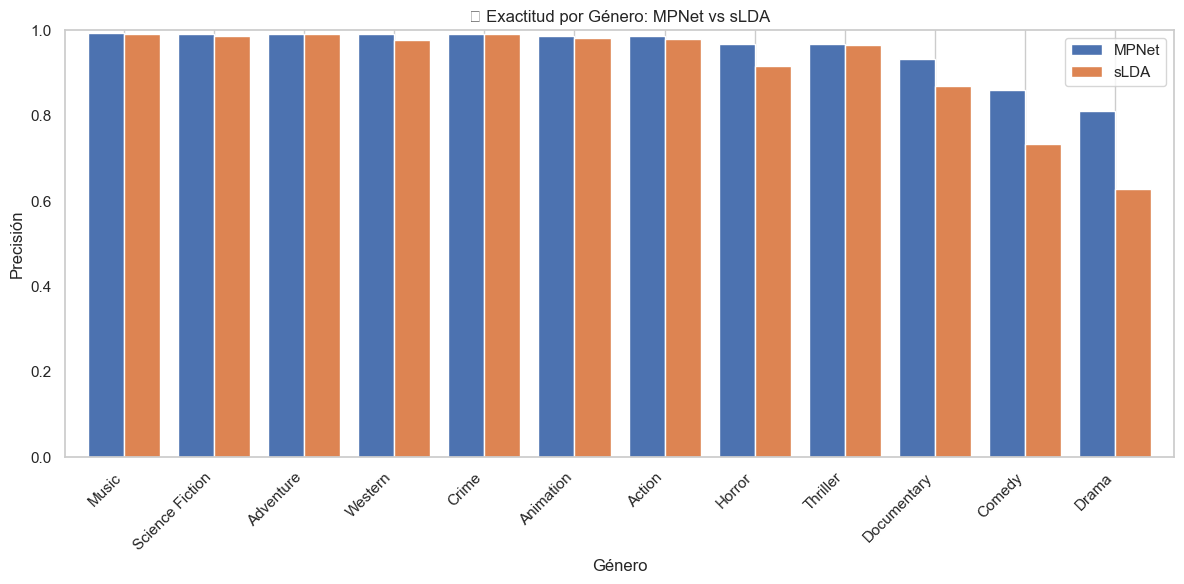

In [41]:
df_precision.plot(kind='bar', figsize=(12, 6), width=0.8)
plt.title('🎯 Exactitud por Género: MPNet vs sLDA')
plt.ylabel('Precisión')
plt.xlabel('Género')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Visualización de matrices de confusión: MPNet vs sLDA

Esta celda genera **matrices de confusión normalizadas** para comparar visualmente el rendimiento de los modelos MPNet y sLDA en la tarea de clasificación multiclase de géneros cinematográficos.

#### Detalles del procedimiento:

1. **Cálculo de matrices de confusión**:
   - Se utilizan las funciones de `scikit-learn` para generar matrices de confusión normalizadas (`normalize='true'`), lo que permite interpretar los resultados en términos de **proporciones de aciertos y errores por clase**.
   - Las etiquetas reales y predichas se extraen de `df_resultados` y se comparan usando el mismo orden de géneros (`genre_names`).

2. **Función personalizada `plot_confusion_heatmap`**:
   - Se crea una función para visualizar las matrices como **mapas de calor** (heatmaps) con `seaborn`.
   - Se redondean los valores a un decimal y se ocultan aquellos por debajo de un umbral (`threshold=0.05`) para mejorar la legibilidad.
   - Se personalizan los ejes, las etiquetas y los colores para facilitar la interpretación visual.

3. **Visualización**:
   - Se grafican las matrices para:
     - **MPNet** usando un esquema de colores azules.
     - **sLDA** usando una paleta naranja.
   - El eje Y representa el género real y el eje X la predicción del modelo.

Estas visualizaciones son útiles para identificar **patrones de confusión frecuentes** (por ejemplo, géneros que se confunden entre sí) y para diagnosticar si un modelo tiende a favorecer ciertas clases o presenta sesgos sistemáticos.


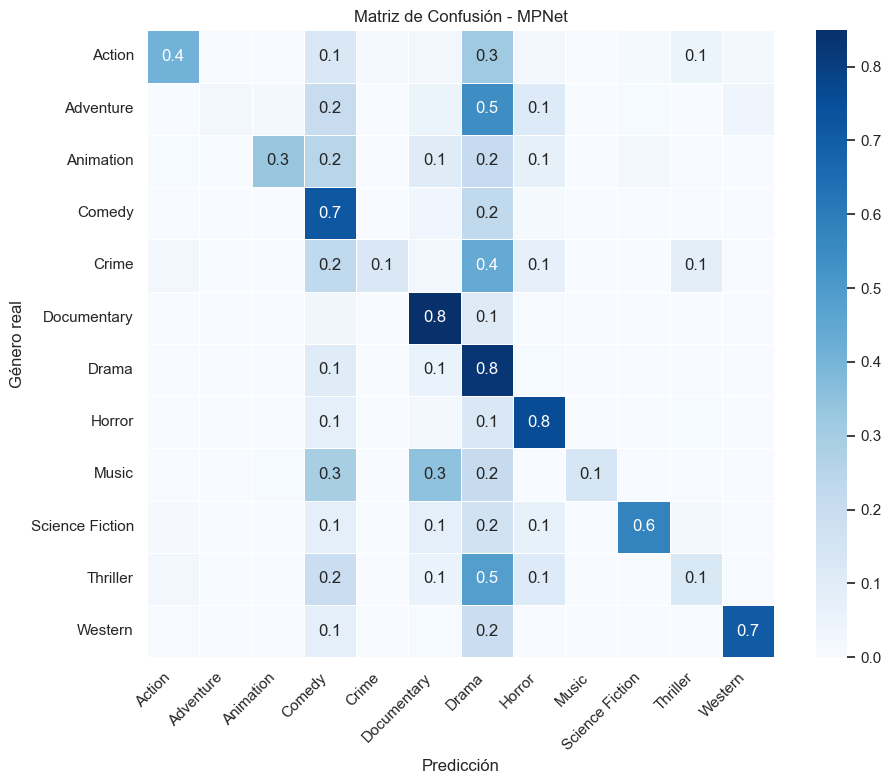

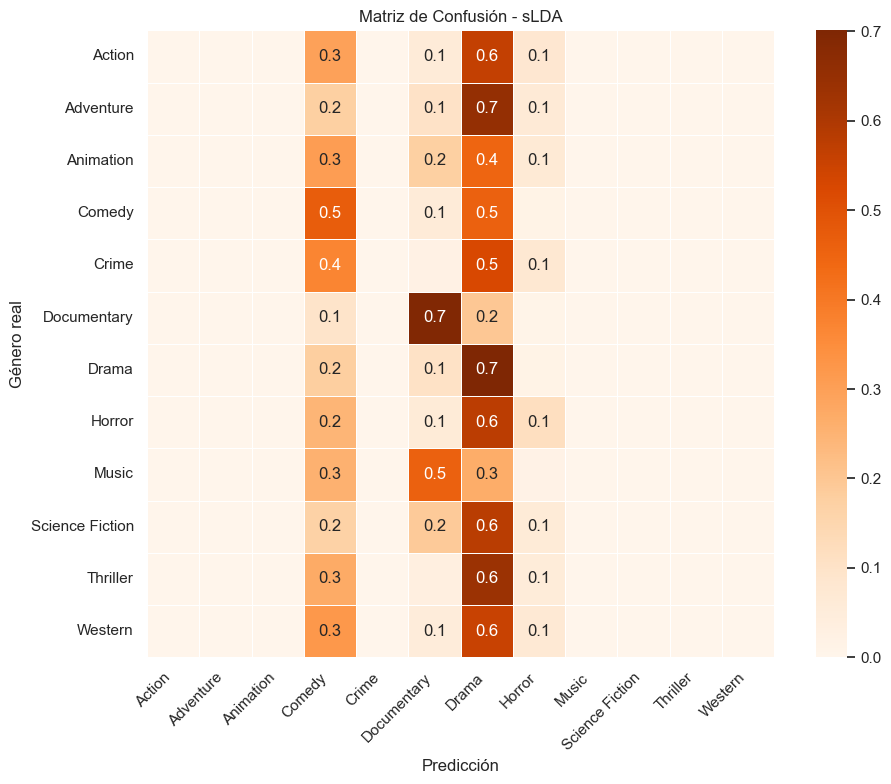

In [42]:

cm_mpnet = confusion_matrix(df_resultados['género_real'], df_resultados['predicción_MPNet'], labels=genre_names, normalize='true')
cm_slda  = confusion_matrix(df_resultados['género_real'], df_resultados['predicción_sLDA'],  labels=genre_names, normalize='true')

def plot_confusion_heatmap(cm, labels, title, cmap='Blues', threshold=0.05):
    # Redondear y enmascarar valores pequeños
    cm_rounded = np.round(cm, 1)
    annot_labels = np.where(cm >= threshold, cm_rounded.astype(str), "")

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=annot_labels, fmt='', cmap=cmap, xticklabels=labels, yticklabels=labels,
                linewidths=0.5, cbar=True, square=True)
    plt.title(title)
    plt.xlabel("Predicción")
    plt.ylabel("Género real")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_confusion_heatmap(cm_mpnet, genre_names, "Matriz de Confusión - MPNet", cmap='Blues')
plot_confusion_heatmap(cm_slda, genre_names, "Matriz de Confusión - sLDA", cmap='Oranges')


### Comparación de métricas por clase: Recall y F1-Score entre MPNet y sLDA

Esta celda analiza en profundidad el desempeño de los modelos MPNet y sLDA a través de las métricas **recall** y **F1-score** calculadas individualmente para cada género.

#### Descripción del procedimiento:

1. **Extracción de etiquetas reales y predichas**:
   - Se extraen las predicciones y etiquetas verdaderas desde el `DataFrame` de resultados, tanto para MPNet como para sLDA.

2. **Cálculo de métricas por clase**:
   - Se calculan tres métricas para cada género:
     - **Precision** (no graficada aquí).
     - **Recall**: proporción de ejemplos positivos correctamente identificados (sensibilidad).
     - **F1-score**: media armónica entre precision y recall, útil cuando hay desbalance de clases.
   - Se usa `average=None` para obtener los valores individualmente por clase, y se garantiza el orden correcto usando `labels=genre_names`.

3. **Construcción de DataFrames para graficar**:
   - Se organizan los resultados en `df_recall` y `df_f1`, que contienen los valores de cada métrica por género y por modelo.

4. **Visualización de métricas**:
   - Se crean gráficos de barras comparativos para:
     - **Recall por género** con una paleta (`Set1`) y escalado entre 0 y 1.
     - **F1-score por género** con otra paleta (`Set2`), también normalizado.
   - Estos gráficos permiten identificar **qué modelo tiene mejor rendimiento por género**, y en qué clases específicas se presentan fortalezas o debilidades.

Este análisis detallado es crucial para evaluar el rendimiento **más allá de la exactitud global**, especialmente cuando se trabaja con múltiples clases potencialmente desbalanceadas.


C:\Users\Oswald\anaconda3\envs\Aplicaciones_ENV\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1200x600 with 0 Axes>

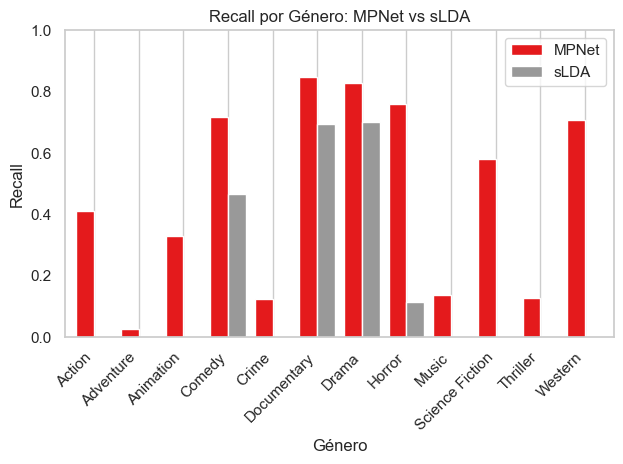

<Figure size 1200x600 with 0 Axes>

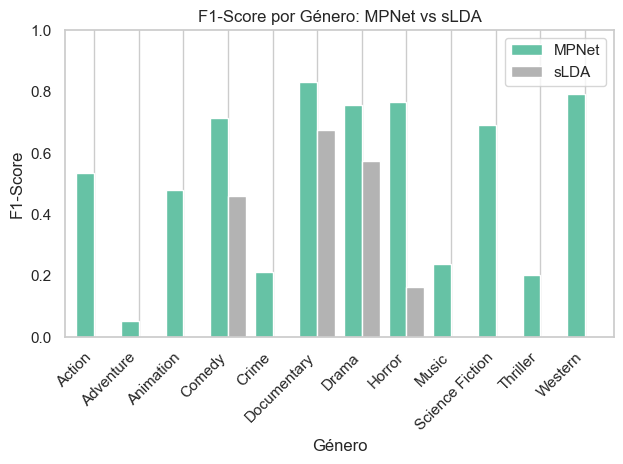

In [43]:

y_true = df_resultados['género_real']
y_pred_mpnet = df_resultados['predicción_MPNet']
y_pred_slda = df_resultados['predicción_sLDA']

# Calcular métricas por clase para MPNet y sLDA
precision_mpnet = precision_score(y_true, y_pred_mpnet, average=None, labels=genre_names)
recall_mpnet = recall_score(y_true, y_pred_mpnet, average=None, labels=genre_names)
f1_mpnet = f1_score(y_true, y_pred_mpnet, average=None, labels=genre_names)

precision_slda = precision_score(y_true, y_pred_slda, average=None, labels=genre_names)
recall_slda = recall_score(y_true, y_pred_slda, average=None, labels=genre_names)
f1_slda = f1_score(y_true, y_pred_slda, average=None, labels=genre_names)

# Crear DataFrames para graficar
df_recall = pd.DataFrame({'MPNet': recall_mpnet, 'sLDA': recall_slda}, index=genre_names)
df_f1 = pd.DataFrame({'MPNet': f1_mpnet, 'sLDA': f1_slda}, index=genre_names)

# Gráfico de Recall
plt.figure(figsize=(12, 6))
df_recall.plot(kind='bar', width=0.8, colormap='Set1')
plt.title('Recall por Género: MPNet vs sLDA')
plt.ylabel('Recall')
plt.xlabel('Género')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Gráfico de F1-score
plt.figure(figsize=(12, 6))
df_f1.plot(kind='bar', width=0.8, colormap='Set2')
plt.title('F1-Score por Género: MPNet vs sLDA')
plt.ylabel('F1-Score')
plt.xlabel('Género')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Relación entre tamaño de clase y recall por modelo

Esta celda analiza cómo influye el **tamaño de cada clase** (número de películas por género) en el **desempeño de los modelos MPNet y sLDA**, específicamente en términos de **recall**.

#### Pasos clave:

1. **Conteo de muestras por género**:
   - Se calcula cuántas películas pertenecen a cada género en el conjunto de datos (`df_clean['genre']`), generando así la variable `Tamaño de clase`.

2. **Construcción del DataFrame de análisis**:
   - Se crea `df_analysis`, que contiene:
     - El número de películas por género.
     - El recall por clase obtenido por MPNet.
     - El recall por clase obtenido por sLDA.

3. **Visualización mediante gráfico de dispersión**:
   - Se grafican los puntos correspondientes al recall por género de ambos modelos respecto al tamaño de la clase.
   - Cada punto representa un género, y se colorea según el modelo:
     - Azul para MPNet.
     - Naranja para sLDA.
   - Además, se anotan los nombres de los géneros sobre cada punto para facilitar su identificación visual.

#### Interpretación esperada:

Este gráfico permite observar si existe una **correlación entre la cantidad de ejemplos disponibles para un género y la capacidad del modelo para reconocerlo correctamente**. En general, se espera que los géneros con más datos tengan un mejor recall, pero el contraste entre MPNet y sLDA también puede revelar **diferencias en la capacidad de generalización o sensibilidad a clases minoritarias**.

Este tipo de visualización es útil para diagnosticar **desequilibrios de clase** y guiar decisiones sobre balanceo, reentrenamiento o ajustes en los modelos.


C:\Users\Oswald\AppData\Local\Temp\ipykernel_6120\2577807813.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(df_analysis['Tamaño de clase'][i], df_analysis['Recall MPNet'][i]+0.02, genre, fontsize=8, color='blue', ha='center')
C:\Users\Oswald\AppData\Local\Temp\ipykernel_6120\2577807813.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(df_analysis['Tamaño de clase'][i], df_analysis['Recall sLDA'][i]-0.04, genre, fontsize=8, color='orange', ha='center')


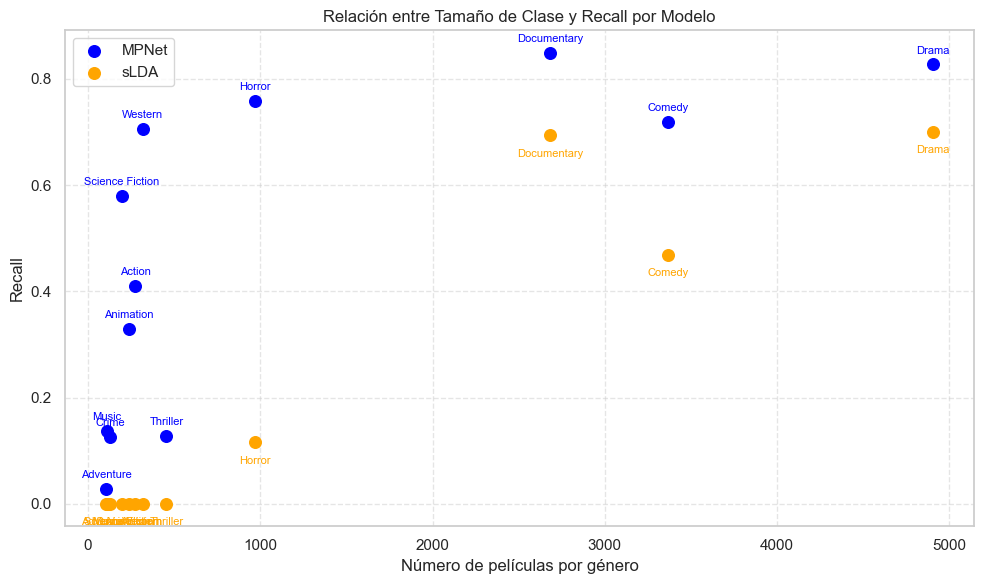

In [44]:
class_counts = df_clean['genre'].value_counts().reindex(genre_names)

# Crear DataFrame de análisis
df_analysis = pd.DataFrame({
    'Tamaño de clase': class_counts,
    'Recall MPNet': recall_mpnet,
    'Recall sLDA': recall_slda
}, index=genre_names)

# Graficar
plt.figure(figsize=(10, 6))
plt.scatter(df_analysis['Tamaño de clase'], df_analysis['Recall MPNet'], label='MPNet', color='blue', s=70)
plt.scatter(df_analysis['Tamaño de clase'], df_analysis['Recall sLDA'], label='sLDA', color='orange', s=70)

# Anotaciones de género
for i, genre in enumerate(df_analysis.index):
    plt.text(df_analysis['Tamaño de clase'][i], df_analysis['Recall MPNet'][i]+0.02, genre, fontsize=8, color='blue', ha='center')
    plt.text(df_analysis['Tamaño de clase'][i], df_analysis['Recall sLDA'][i]-0.04, genre, fontsize=8, color='orange', ha='center')

plt.title('Relación entre Tamaño de Clase y Recall por Modelo')
plt.xlabel('Número de películas por género')
plt.ylabel('Recall')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### Tabla comparativa de métricas por género: MPNet vs sLDA

Esta celda resume de manera estructurada las métricas más relevantes para cada modelo de clasificación (**MPNet** y **sLDA**) agrupadas por género cinematográfico. La tabla generada (`df_metrics`) permite comparar el rendimiento de ambos enfoques en detalle, clase por clase.

#### Métricas calculadas:

1. **Tamaño de clase**:
   - Número de películas disponibles para cada género en el conjunto de datos (`df_clean`).
   - Esta variable ayuda a contextualizar el rendimiento de cada modelo respecto al desbalance de clases.

2. **Precision**:
   - Proporción de verdaderos positivos entre todas las predicciones positivas para cada clase.
   - Se calcula por separado para MPNet y sLDA.

3. **Recall**:
   - Proporción de verdaderos positivos entre todos los ejemplos reales de la clase.
   - Mide la sensibilidad del modelo ante cada género.

4. **F1-Score**:
   - Media armónica entre precision y recall.
   - Resume en un solo valor la capacidad del modelo para ser preciso y completo.

5. **Exactitud por clase real**:
   - Proporción de casos correctamente clasificados dentro del conjunto total de ejemplos reales de cada clase.
   - Equivale a la diagonal normalizada de la matriz de confusión (aciertos entre los verdaderos del género).

#### Objetivo de la tabla:

Este análisis por género permite identificar:
- Qué géneros son más fáciles o más difíciles de clasificar.
- Cuál de los dos modelos tiene mejor desempeño en cada clase.
- La relación entre el tamaño de la clase y la calidad de las predicciones.

Redondear los valores facilita su presentación y comparación visual en informes o presentaciones.


In [45]:
# Obtener tamaño de clase
class_counts = df_clean['genre'].value_counts().reindex(genre_names)

# Calcular precisión, recall y F1
precision_mpnet = precision_score(y_true, y_pred_mpnet, average=None, labels=genre_names)
recall_mpnet = recall_score(y_true, y_pred_mpnet, average=None, labels=genre_names)
f1_mpnet = f1_score(y_true, y_pred_mpnet, average=None, labels=genre_names)

precision_slda = precision_score(y_true, y_pred_slda, average=None, labels=genre_names)
recall_slda = recall_score(y_true, y_pred_slda, average=None, labels=genre_names)
f1_slda = f1_score(y_true, y_pred_slda, average=None, labels=genre_names)

# Calcular exactitud por clase real (coincide con gráfica de barras)
def exactitud_por_clase(y_true, y_pred, label_list):
    return pd.Series({
        label: accuracy_score(
            [y == label for y in y_true],
            [p == label for p in y_pred]
        )
        for label in label_list
    })

accuracy_mpnet = exactitud_por_clase(y_true, y_pred_mpnet, genre_names)
accuracy_slda  = exactitud_por_clase(y_true, y_pred_slda, genre_names)

# Crear tabla
df_metrics = pd.DataFrame({
    'Tamaño de clase': class_counts,
    'Precision MPNet': precision_mpnet,
    'Recall MPNet': recall_mpnet,
    'F1 MPNet': f1_mpnet,
    'Exactitud MPNet': accuracy_mpnet,
    'Precision sLDA': precision_slda,
    'Recall sLDA': recall_slda,
    'F1 sLDA': f1_slda,
    'Exactitud sLDA': accuracy_slda
}, index=genre_names)

# Redondear para presentación
df_metrics = df_metrics.round(3)

# Mostrar tabla
display(df_metrics)

C:\Users\Oswald\anaconda3\envs\Aplicaciones_ENV\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Tamaño de clase,Precision MPNet,Recall MPNet,F1 MPNet,Exactitud MPNet,Precision sLDA,Recall sLDA,F1 sLDA,Exactitud sLDA
Action,275,0.774,0.411,0.537,0.986,0.000,0.000,0.000,0.980
Adventure,107,0.600,0.028,0.054,0.992,0.000,0.000,0.000,0.992
Animation,237,0.886,0.329,0.480,0.988,0.000,0.000,0.000,0.983
Comedy,3365,0.713,0.719,0.716,0.860,0.456,0.468,0.462,0.733
Crime,127,0.667,0.126,0.212,0.991,0.000,0.000,0.000,0.991
Documentary,2683,0.813,0.849,0.831,0.932,0.661,0.694,0.677,0.871
Drama,4903,0.697,0.828,0.757,0.810,0.485,0.701,0.574,0.628
Horror,971,0.774,0.759,0.767,0.967,0.290,0.115,0.165,0.918
Music,109,0.938,0.138,0.240,0.993,0.000,0.000,0.000,0.992
Science Fiction,195,0.863,0.579,0.693,0.993,0.000,0.000,0.000,0.986


### Análisis de solapamiento entre clases mediante KDE para el género "Comedy"

Esta celda visualiza la **distribución de probabilidades predichas** por el modelo sLDA para el género **"Comedy"**, utilizando estimaciones de densidad kernel (KDE). El objetivo es evaluar qué tan bien el modelo separa las películas de comedia del resto.

#### Detalles del procedimiento:

1. **Preparación de los datos**:
   - Se crea una copia de `df_clean` (`df_kde`) y se añade:
     - `proba_comedy`: la probabilidad predicha por el modelo sLDA para el género "Comedy".
     - `is_comedy`: una etiqueta booleana que indica si la película pertenece realmente al género "Comedy".

2. **Visualización con KDE**:
   - Se generan dos curvas KDE (Kernel Density Estimate):
     - Una para las películas que **sí son comedia** (`is_comedy=True`), en verde.
     - Otra para las que **no son comedia**, en rojo.
   - El eje X representa la probabilidad estimada de que una película sea comedia.
   - El eje Y representa la densidad estimada (frecuencia relativa suavizada).

#### Interpretación:

- Si el modelo separa bien las clases, se espera que las curvas estén claramente **separadas**, con mínimos solapamientos.
- Un solapamiento amplio entre las distribuciones sugiere **dificultades del modelo para distinguir** entre comedia y otros géneros.
- La visualización ayuda a entender la **calidad de la calibración del modelo** y si sería útil ajustar el umbral de decisión o incorporar medidas de incertidumbre.

Este tipo de gráfico es útil para complementar métricas clásicas y visualizar **comportamientos probabilísticos del modelo** sobre un subconjunto binario del problema multiclase.



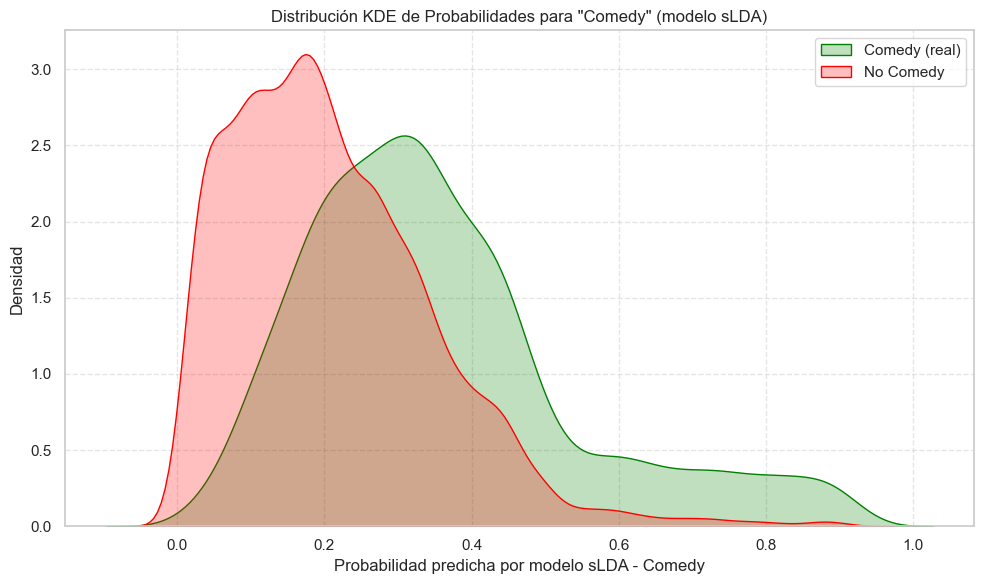

In [46]:
df_kde = df_clean.copy()
df_kde['proba_comedy'] = df_slda_pred['Comedy']  # Probabilidad predicha para 'Comedy'
df_kde['is_comedy'] = df_kde['genre'] == 'Comedy'

# Gráfico KDE real
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_kde[df_kde['is_comedy']], x='proba_comedy', label='Comedy (real)', fill=True, color='green')
sns.kdeplot(data=df_kde[~df_kde['is_comedy']], x='proba_comedy', label='No Comedy', fill=True, color='red')

plt.title('Distribución KDE de Probabilidades para "Comedy" (modelo sLDA)')
plt.xlabel('Probabilidad predicha por modelo sLDA - Comedy')
plt.ylabel('Densidad')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()